# CorrDiff Style Residual Prediction with a Diffusion (EDM) Model
The models we've built so far produce relatively stable output. The "class" of the predictions is often correct, but the variance of the predictions is much lower than the variance present in the actual dataset. This is where generative modeling -- estimating and sampling from the underlying data disribution -- can be useful. Diffusion models are one such way to achieve this. We'll be using the design framework described in ["Elucidating the Design Space of Diffusion-Based Generative Models"](https://arxiv.org/abs/2206.00364) (Karras 2022).

In [1]:
import os
import sys
import datetime
import json
import time
from tqdm import tqdm 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from accelerate import Accelerator, notebook_launcher

#local imports
package_root = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.join(package_root, "models"))
sys.path.insert(0, os.path.join(package_root, "data"))
sys.path.insert(0, os.path.join(package_root, "utils"))
from cnn_autoencoder import ConvAutoEncoder
from unet_denoiser import DenoisingUNet
from datasets import MNISTNextDigitResidualDataset
from diffusion_utils import EDMPrecond, EDMLoss, StackedRandomGenerator, edm_sampler
from utils import save_model_checkpoint


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## New Dataset for Residuals

Our (machine) learning objective has now changed. We are no longer trying to directly predict the image of the next digit. Instead, we will try to predict the residuals (i.e. the errors) of one of our previous models' predictions. This means we need a new Dataset class: **MNISTNextDigitResidualDataset**. The key features of this new class are:

- Instantiating requires a pretrained base model in addition to the train/test flag.
- Indexing will return a model prediction and residual pair. To get the original digit pair, just call `get_digits(idx)`.

You can find the source code in datasets.py (or by clicking [here](https://github.com/marshallrbaldwin/PyTorch_MNIST_Tutorial/blob/faf59757fa2447c995e778989f227ed7520a595f/datasets.py#L54)).

## Denoiser Architecture

The NN architecture we'll be using to build a (conditional) denoising model is a U-Net with FiLM'd convolutional blocks. 

### FiLM Blocks

Unlike our previous models, this denoiser architecture takes in three channels of information as inputs: a noised image, an image generated by a base model, and a scalar noise "coordinate" $\sigma$ or $t$. The first two can be added as channels in our input stack of images without any preprocessing. But the third is not so simple. Instead of creating a third image, we can instead use **F**eature-w**i**se **L**inear **M**odulation (see [Perez et al. 2017](https://doi.org/10.48550/arXiv.1709.07871)) to modify the behavior of convolutional blocks directly. The idea is to apply an affine transformation -- i.e. scale by a weight ($\gamma_{channel}$) and add a bias ($\beta_{channel}$) -- to each channel generated in a colvolutional layer (see [this blog post](https://distill.pub/2018/feature-wise-transformations/) for an interactive demo). 

To produce the $\gamma$ and $\beta$ vectors, each FiLM block needs some mapping from $F:\sigma \rightarrow \gamma,\beta$. This mapping is an architecture decision. Instead of using an MLP layer, $F$ is defined in a two step process. The first step is to lift $\sigma$ into an embedding space via sinusoidal position encoding a la NLP modelling (see [the code](https://github.com/marshallrbaldwin/PyTorch_MNIST_Tutorial/blob/faf59757fa2447c995e778989f227ed7520a595f/unet_denoiser.py#L158)). The second step is to make a linear map from the $\sigma$ embedding to $\gamma$ and $\beta$. In [the code](https://github.com/marshallrbaldwin/PyTorch_MNIST_Tutorial/blob/faf59757fa2447c995e778989f227ed7520a595f/unet_denoiser.py#L53), this is done by mapping to a vector containing both $\gamma$ and $\beta$ and then splitting it.

<div align="center">
    <img src="images/FiLM_Block_Diagram.JPEG" width="50%">
</div>

### U-Net Architecture

A U-Net architecture is an extension to the convolutional autoencoder. The main difference is the inclusion of skip connections from the encoder path to the decoder path. The output of the encoder's convolutional blocks (prior to avg pooling) are appended as extra channels input to the decoder's convolutional blocks. This is done to retain spatial information that may be destroyed during the encoding portion of the model. It should be noted that if your output is not spatially correlated with your input, then these additional channels may not improve skill. However, both input channels to the denoiser, the noise itself and the fuzzy base model prediction, are spatially correlated with the final residual prediction.

The diagram below shows the information flow through our FiLM'd denoising U-Net with the following hyperparameters:

- n_conv_filters=\[3, 4, 5]
- n_layers_per_block=2
- n_bottleneck_blocks=2

<div align="center">
    <img src="images/Denoising_UNet_Diagram.JPEG" width="80%">
</div>

## EDM Training Quirks

From the *diffusion_utils.py* script, there are two classes required for training an EDM model:

- **EDMPrecond**

    - This is a wrapper around your denoising PyTorch model. Its main purpose is to apply the "preconditioning" scaling factors described in Section 5 of Karras 2022, the  derivations of which are described in Appendix B.6.

    - For practical use, the wrapped model *is* your denoising model. It only alters the behavior of your base denoising model when called to make a prediction.

- **EDMLoss**

    - Calling this class encapsulates more functionality than just computing a loss. It is responsible for determining the $\sigma$ level of a given sample (i.e. how much noise to add). Each $\sigma$ is drawn from a log-normal distribution, P, whose shape is determined by two hyperparameters (*P_mean* and *P_std*).
    - Once a $\sigma$ level is selected, noise from $\mathcal{N}(0,\sigma^2)$ is added to the clean image.
    - The denoiser is then asked to remove noise *entirely* from the image.
    - The mean squared error is computed between the true residuals and the denoised residuals.
    - This error is then scaled by another preconditioning factor (see Section 5 -- "Loss weighting and sampling" -- of Karras 2022 for a discussion) before being returned as the loss for that sample


## Define Training Parameters

In [2]:
#training configuration
batch_size = 128
learning_rate = 1e-3
num_epochs = 5
grad_clipnorm = 1 #gradients normed to this value (typically 1)
num_dataloader_workers = 2 # Number of separate processes to load data during training (2-8 usually sufficient)
gradient_accumulation_steps = 1 # Number of batches to run before adjusting weights. 1 typically, >1 if GPU memory limited
precision = "fp16" #always use float 16. Helps with speed and GPU memory

#load pre-trained "fuzzy" model
epoch = 4
model_name = "ConvAutoEncoder"
base_model = ConvAutoEncoder( #TODO: Encapsulate hyperparameters in picklable object
    n_input_channels = 1,
    n_output_channels = 1,
    n_conv_filters = [64, 64],
    n_layers_per_block = 3
)
checkpoint = torch.load(os.path.join(package_root, "models", "MNIST_num2num", "model_checkpoints", model_name,f"epoch{epoch}.pth"), weights_only=True)
base_model.load_state_dict(checkpoint['model_state_dict'])
base_model.eval()
base_model.to(("cuda"))

#load datasets
train_ds = MNISTNextDigitResidualDataset(base_model, is_train = True)
test_ds = MNISTNextDigitResidualDataset(base_model, is_train = False)

#put datasets into DataLoaders so PyTorch handles batches and shuffling
train_dataloader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

#set up our denoising model's architecture
denoiser = DenoisingUNet(
                 channels_in=1+1, # one channel for noise, the other for fuzzy conv model output
                 channels_out=1,
                 n_conv_filters=[32, 32, 32], #two downsampling steps with 32 filters and 32 filters in the bottleneck 
                 n_layers_per_block=3, #three sets of convolutions before pooling
                 n_bottleneck_blocks=3, #three sets of convolutions in botteneck
                 cond_embedding_dim=16) #sigma embedding dimension

#wrap denoiser in the EDM preconditioner (a few fancy weights)
img_resolution = (28, 28)
num_label_channels = 1 #number of channels to be diffused
denoiser_wrapped =  EDMPrecond(img_resolution, num_label_channels, denoiser)

#create our optimizer and loss function
optimizer = torch.optim.Adam(denoiser_wrapped.parameters(), lr = learning_rate)
loss_function = EDMLoss(P_mean=0., P_std=1.2, sigma_data = 1.)

#create HuggingFace Accelerator object and wrap training components
accelerator = Accelerator(
    gradient_accumulation_steps = gradient_accumulation_steps, 
    mixed_precision = precision)

train_dataloader, test_dataloader, denoiser, optimizer = accelerator.prepare(train_dataloader, test_dataloader, denoiser_wrapped, optimizer)

## Training Loop

In [3]:
denoiser_name = "unet_denoiser"
#run our usual training loop
for epoch in range(num_epochs):

    denoiser.train()
    for batch_num, data in enumerate(tqdm(train_dataloader, leave = False)): #tqdm just makes nice progress bars
        with accelerator.accumulate(denoiser):

            X, y = data

            with accelerator.autocast():
                loss = loss_function(denoiser, y, X).mean()

            accelerator.backward(loss)
            if accelerator.sync_gradients: #included for multi-gpu training
                accelerator.clip_grad_norm_(denoiser.parameters(), grad_clipnorm) #prevents exploding gradients
                optimizer.step()
                optimizer.zero_grad()

    #if accelerator.is_main_process:
        #evaluate_model(model, loss_function, test_dataloader)
        save_model_checkpoint(epoch, accelerator.unwrap_model(denoiser), optimizer, loss, model_name = denoiser_name)

## Save Trained Denoiser

In [4]:
# unwrap the model from Accelerator
final_model = accelerator.unwrap_model(denoiser)

# save path
save_dir = os.path.join(package_root, "models", "MNIST_num2num", "model_checkpoints", denoiser_name)
os.makedirs(save_dir, exist_ok=True)

# save state_dict
torch.save({
    'epoch': epoch,
    'model_state_dict': final_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, os.path.join(save_dir, f'epoch{epoch+1}_final.pth'))

## Generating a Sample Using the Denoiser

We now have a denoiser which, given a noised image and associated condition channels, 
TODO: Describe the Heun solver. Describe ODE vs SDE decision. Describe sigma step distribution.

## Plotting Results: TODO - tidy up

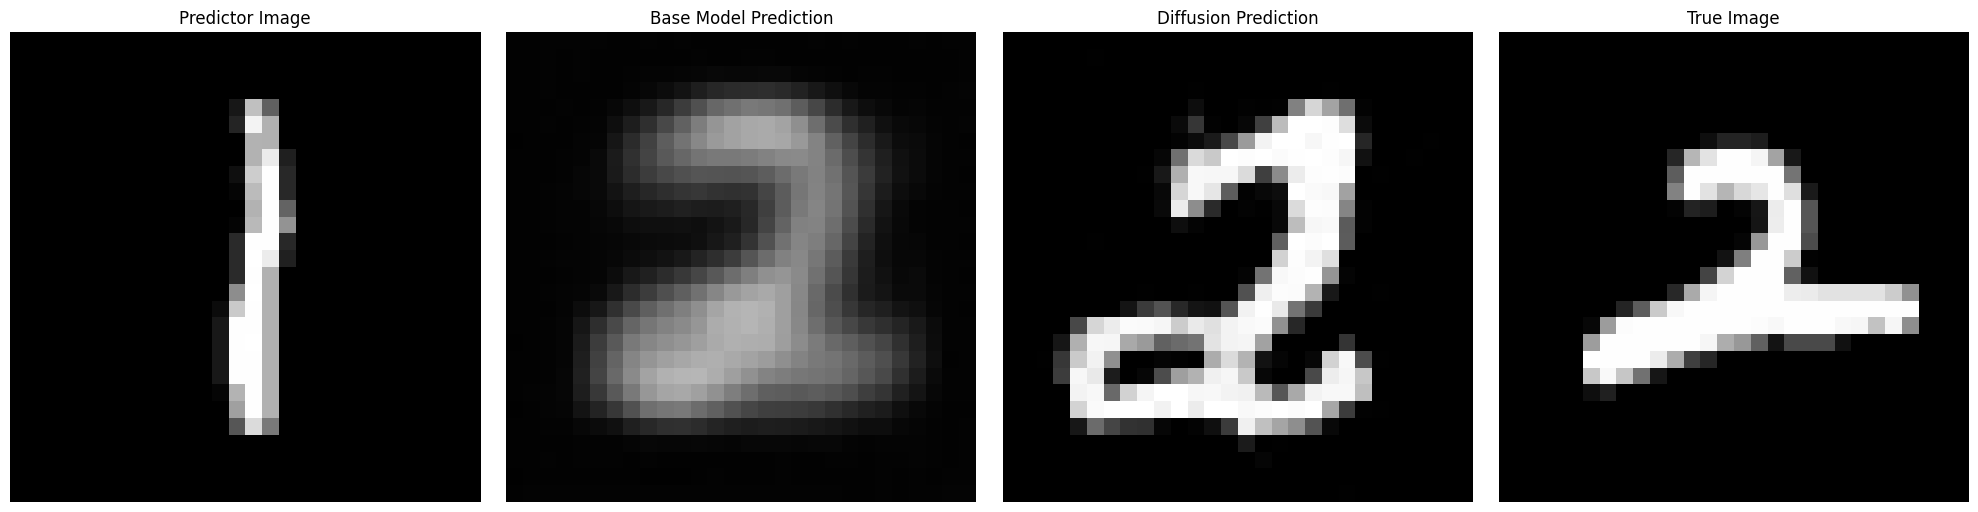

In [5]:
def plot_diff_pred(X, y, base_pred, diffusion_pred, save_name = None):
    """
    X, y, and pred are all numpy arrays of dimension (28, 28)
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(X.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[0].set_title(f"Predictor Image")
    axes[0].axis("off")
    axes[1].imshow(base_pred.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[1].set_title(f"Base Model Prediction")
    axes[1].axis("off")
    axes[2].imshow(base_pred.squeeze() - diffusion_pred.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[2].set_title(f"Diffusion Prediction")
    axes[2].axis("off")
    axes[3].imshow(y.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[3].set_title(f"True Image")
    axes[3].axis("off")
    plt.tight_layout()
    if save_name:
        plt.savefig(f"{save_name}.png")
    plt.show()

device = "cuda"
test_ds = MNISTNextDigitResidualDataset(base_model, is_train = False)
rnd = StackedRandomGenerator(device, [np.random.randint(1000)]) #device and seed of some random number
digit_idx = np.random.randint(20000)
X, y = test_ds.get_digits(digit_idx)
inputs, labels = test_ds[digit_idx] #fuzzy base model prediction and true residuals
inputs = torch.from_numpy(inputs[np.newaxis,...]).to(device)
latents = rnd.randn((1,) + labels.shape, device = device)
pred_residuals = edm_sampler(denoiser, latents, inputs, S_churn=0., num_steps = 18)

base_pred_np = inputs.cpu().numpy().squeeze()
pred_residuals_np = pred_residuals.cpu().numpy().squeeze()
#plt.imshow(pred_residuals_np, cmap = "RdBu", vmin = -1., vmax = 1.)

plot_diff_pred(X, y, base_pred_np, pred_residuals_np)

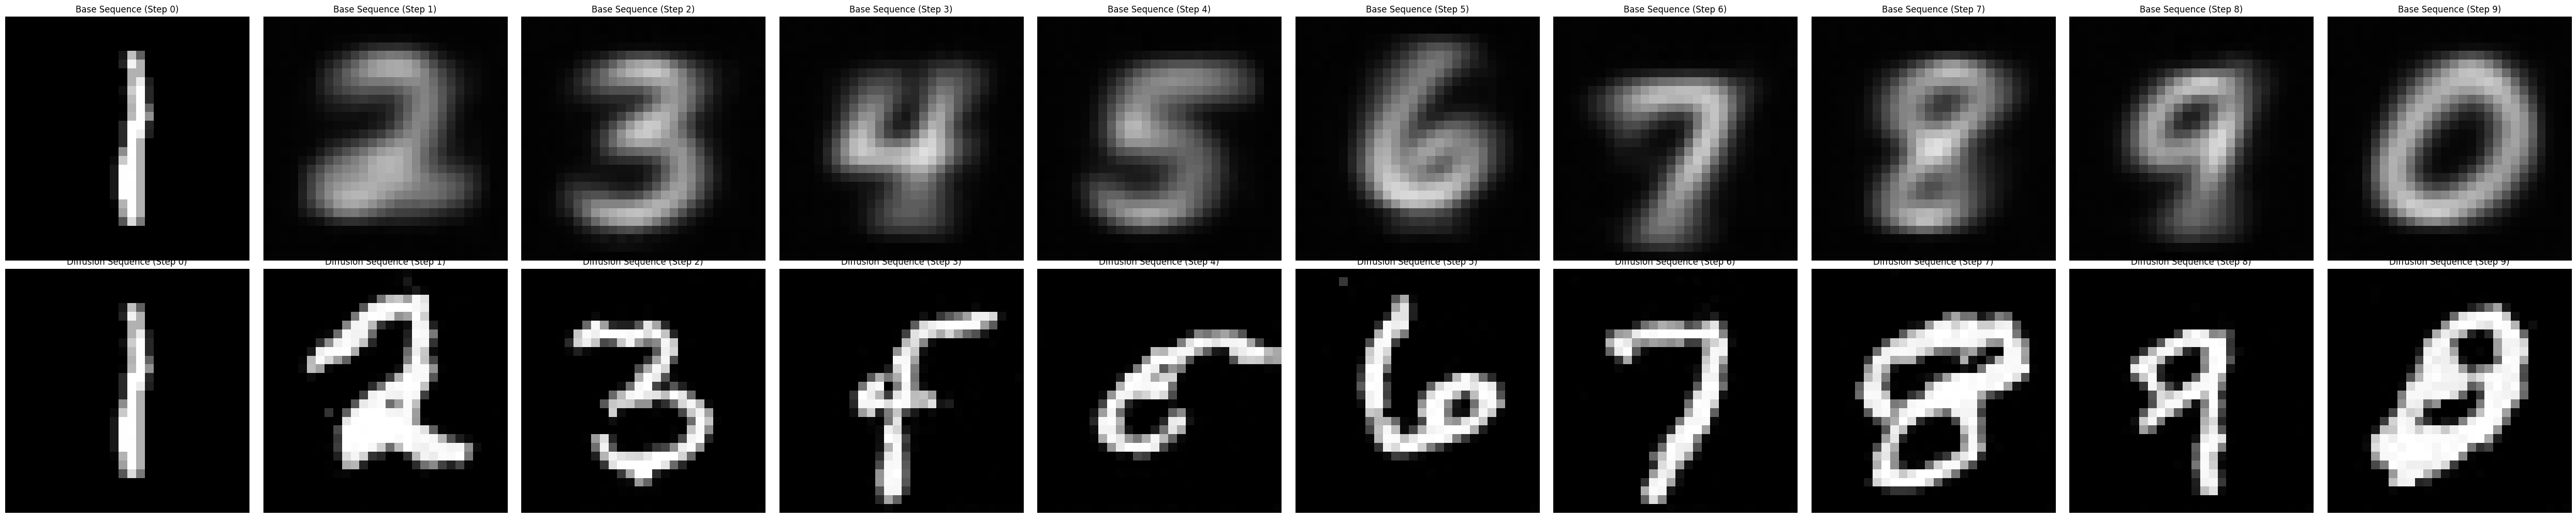

In [6]:
def plot_autoregressive_sequence_corrected(X, base_model, diffusion_model, edm_sampler, n_steps=3):
    """
    Runs autoregressive rollout with the base model, then corrects each prediction using diffusion residuals.

    :param X: numpy array - Original predictor image
    :param base_model: torch.nn.Module - Base predictive model
    :param diffusion_model: torch.nn.Module - Diffusion model for residual correction
    :param edm_sampler: function - EDM sampler to generate diffusion residuals
    :param n_steps: int - Number of autoregressive steps
    """
    device = next(base_model.parameters()).device  # Get model's device
    X_gpu = torch.from_numpy(X).unsqueeze(0).to(device, dtype=torch.float32)  # Ensure float32

    base_predictions = [X]  # Store base model predictions
    current_input = X_gpu

    #run base model roll-out
    with torch.no_grad():
        for _ in range(n_steps):
            base_pred = base_model(current_input).to(torch.float32)  
            base_pred_np = base_pred.cpu().numpy()
            base_predictions.append(base_pred_np)  # Store prediction

            # Use prediction as next input
            current_input = torch.from_numpy(base_pred_np).to(device, dtype=torch.float32)
            if current_input.dim() == 3:  
                current_input = current_input.unsqueeze(0)

    #apply diffusion-generated residuals to each step of the roll-out 
    corrected_predictions = [X]  # Start with original predictor
    with torch.no_grad():
        for base_pred_np in base_predictions[1:]:  # Skip the original X
            base_pred = torch.from_numpy(base_pred_np).to(device, dtype=torch.float32)
            latents = torch.randn_like(base_pred, dtype=torch.float32, device=device)  # Ensure float32
            pred_residuals = edm_sampler(diffusion_model, latents, base_pred, S_churn=0., num_steps=18).to(torch.float32)
            pred_residuals_np = pred_residuals.cpu().numpy()

            corrected_pred_np = base_pred_np - pred_residuals_np  # Apply correction
            corrected_predictions.append(corrected_pred_np)

    #plot the two prediction sequences
    n_cols = n_steps + 1  # Original + n_steps
    fig, axes = plt.subplots(2, n_cols, figsize=(5 * n_cols, 10))

    # Plot base model predictions
    for i in range(n_cols):
        axes[0, i].imshow(base_predictions[i].squeeze(), cmap="gray", vmin=0., vmax=1.)
        axes[0, i].set_title(f"Base Sequence (Step {i})")
        axes[0, i].axis("off")

    # Plot corrected predictions
    for i in range(n_cols):
        axes[1, i].imshow(corrected_predictions[i].squeeze(), cmap="gray", vmin=0., vmax=1.)
        axes[1, i].set_title(f"Diffusion Sequence (Step {i})")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

plot_autoregressive_sequence_corrected(X, base_model, denoiser, edm_sampler, n_steps=9)